In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

In [6]:
df = pd.read_excel('greycom_sales_noOut.xlsx')

#rename columns to something more understandable
df.rename(columns={'DataEmissao':'date', 'Qtd':'quant'}, inplace=True)

#convert date column to datetime type
df['date'] = pd.to_datetime(df.date)

df['day_of_week'] = df['date'].dt.day_name()

#df.set_index('date', inplace=True)

df

,date,SKU,quant,day_of_week
0,2023-12-20,AWR1-110X74,72,Wednesday
1,2023-12-20,AWR1-110X74,72,Wednesday
2,2023-12-20,AWR1-110X74,72,Wednesday
3,2023-12-20,TC193,70,Wednesday
4,2023-12-20,AWR1-110X74,48,Wednesday
...,...,...,...,...
125191,2024-08-02,L42PROFULL,1,Friday
125192,2024-08-02,MP4200,1,Friday
125193,2024-08-02,TC270,1,Friday
125194,2024-08-02,QSADRP10.1KG,1,Friday


In [7]:
# Step 1: Aggregate the data by SKU and date
df_c = df.groupby(['SKU', 'date'], as_index=False).agg({'quant': 'sum'})

# Step 2: Convert the 'date' column to datetime format (if it isn't already)
df_c['date'] = pd.to_datetime(df_c['date'])

# Step 3: Set 'date' as the index
df_c.set_index('date', inplace=True)

df_c #this now contains all daily collapsed sales for each SKU, with all dates for the first SKU, then the same for the next and so on


,SKU,quant
date,,
2023-12-20,"100X150T27,0M",220
2023-12-21,"100X150T27,0M",190
2023-12-22,"100X150T27,0M",135
2023-12-23,"100X150T27,0M",15
2023-12-24,"100X150T27,0M",10
...,...,...
2024-07-25,ZSTXROXO,1
2024-07-26,ZSTXROXO,1
2024-07-31,ZSTXROXO,1


In [8]:
sku = 'TC213'
sku_df = df_c[df_c['SKU'] == sku].copy()

# Step 1: Feature Engineering
sku_df['lag_1'] = sku_df['quant'].shift(1)
sku_df['rolling_mean_3'] = sku_df['quant'].rolling(window=3).mean()
sku_df['dayofweek'] = sku_df.index.dayofweek
sku_df['month'] = sku_df.index.month
sku_df['dayofmonth'] = sku_df.index.day

sku_df.dropna(inplace=True)

sku_df

,SKU,quant,lag_1,rolling_mean_3,dayofweek,month,dayofmonth
date,,,,,,,
2023-12-22,TC213,50,35.0,35.000000,4,12,22
2023-12-23,TC213,27,50.0,37.333333,5,12,23
2023-12-24,TC213,10,27.0,29.000000,6,12,24
2023-12-25,TC213,8,10.0,15.000000,0,12,25
2023-12-26,TC213,60,8.0,26.000000,1,12,26
...,...,...,...,...,...,...,...
2024-07-29,TC213,9,2.0,5.000000,0,7,29
2024-07-30,TC213,52,9.0,21.000000,1,7,30
2024-07-31,TC213,172,52.0,77.666667,2,7,31


In [19]:
import xgboost as xgb
import contextlib
import os
import sys
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Function to train model and predict future quantities for a specific SKU
def predict_for_sku(sku, df, prediction_length=30):
    # Filter data for the specific SKU
    sku_df = df[df['SKU'] == sku].copy()

    # Step 1: Feature Engineering
    sku_df['lag_1'] = sku_df['quant'].shift(1)
    sku_df['rolling_mean_3'] = sku_df['quant'].rolling(window=3).mean()
    sku_df['dayofweek'] = sku_df.index.dayofweek
    sku_df['month'] = sku_df.index.month
    sku_df['dayofmonth'] = sku_df.index.day

    sku_df.dropna(inplace=True)

    # Step 2: Train/Test Split
    train = sku_df[sku_df.index < '2024-07-01']
    test = sku_df[sku_df.index >= '2024-07-01']

    feature_columns = ['lag_1', 'rolling_mean_3', 'month', 'dayofweek', 'dayofmonth']
    TARGET = 'quant'

    X_train = train[feature_columns]
    y_train = train[TARGET]

    X_test = test[feature_columns]
    y_test = test[TARGET]

    # Step 3: Train the XGBoost Model
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
    with contextlib.redirect_stdout(open(os.devnull, 'w')): #gets rid of the verbose when running the model 
        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    # Step 4: Predict the Future
    future_dates = pd.date_range(start='2024-08-01', periods=prediction_length, freq='D')
    future_df = pd.DataFrame(index=future_dates)
    future_df['month'] = future_df.index.month
    future_df['dayofweek'] = future_df.index.dayofweek
    future_df['dayofmonth'] = future_df.index.day

    # Handling the lag_1 feature initialization
    if not test.empty and len(test) > 0:  # Check if the test DataFrame is not empty
        future_df['lag_1'] = test['quant'].iloc[-1]  # Use the last value from test DataFrame
    else:
        if not train.empty and len(train) > 0:  # Fallback to the last value in train if test is empty
            future_df['lag_1'] = train['quant'].iloc[-1]
        else:
            future_df['lag_1'] = 0  # Fallback to a default value if both test and train are empty or invalid

    rolling_window = 3
    predictions = []

    for date in future_df.index:
        # Update rolling mean
        if len(predictions) >= rolling_window:
            future_df.at[date, 'rolling_mean_3'] = np.mean(predictions[-rolling_window:])
        else:
            future_df.at[date, 'rolling_mean_3'] = np.mean(predictions)
            
        # Ensure features are aligned before prediction
        features = future_df.loc[date, feature_columns].values.reshape(1, -1)
        prediction = reg.predict(features)
        predictions.append(prediction[0])
            
        # Update lag feature for the next prediction
        future_df.at[date, 'lag_1'] = prediction[0]

    future_df['predicted_value'] = predictions
    future_df['SKU'] = sku

    return future_df[['predicted_value', 'SKU']]

In [20]:
# Step 5: Loop over all SKUs and store predictions
def generate_predictions_all_skus(df, prediction_length=30):
    unique_skus = df['SKU'].unique()
    all_predictions = pd.DataFrame()

    for sku in unique_skus:
        sku_predictions = predict_for_sku(sku, df, prediction_length)
        all_predictions = pd.concat([all_predictions, sku_predictions])

    return all_predictions

In [21]:
# Step 6: Function to retrieve predictions for a specific SKU and plot
def get_predictions_for_sku(sku, all_sku_predictions):
    sku_predictions = all_sku_predictions[all_sku_predictions['SKU'] == sku]
    
    # Plot the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(sku_predictions.index, sku_predictions['predicted_value'], label=f'Predicted for {sku}', color='r')
    plt.xlabel('Date')
    plt.ylabel('Predicted Quantity')
    plt.title(f'Predicted Sales for SKU: {sku}')
    plt.legend()
    plt.show()

    return sku_predictions

/Users/emtruzzi/miniconda3/envs/scient/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emtruzzi/miniconda3/envs/scient/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/k8/hhz0yyvj6qj76b46zqvs9w0r0000gn/T/ipykernel_39291/3350019056.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '593.188720703125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future_df.at[date, 'lag_1'] = prediction[0]
/Users/emtruzzi/miniconda3/envs/scient/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emtruzzi/miniconda3/envs/scient/lib/python3.12/site-packages/n

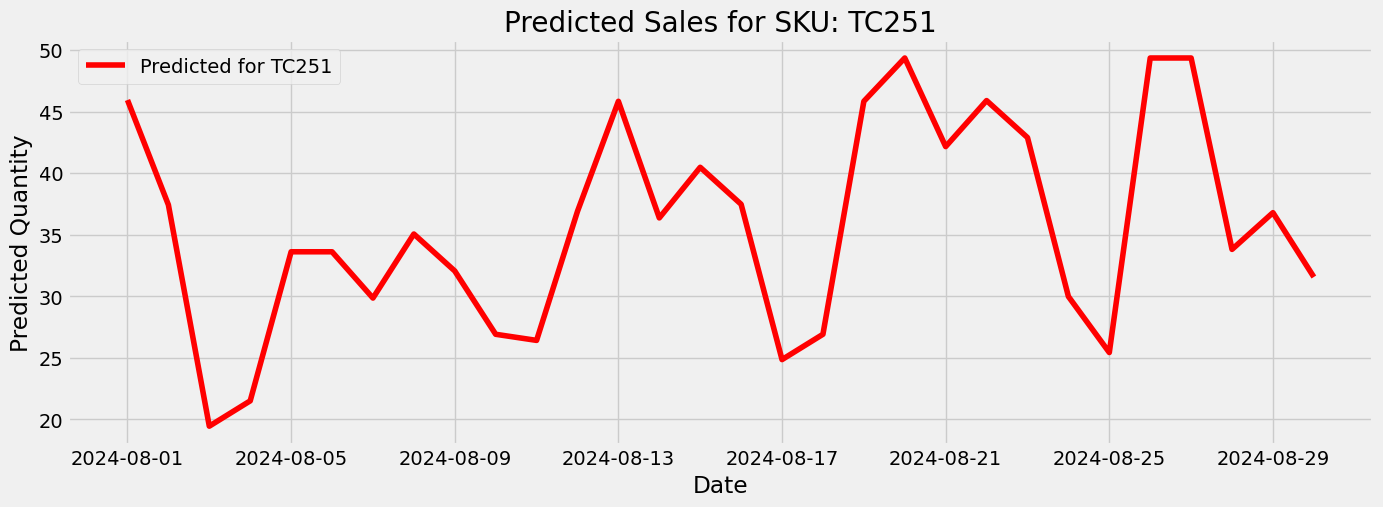

In [22]:
# Generate predictions for all SKUs
all_sku_predictions = generate_predictions_all_skus(df_c)

# Example usage to get predictions and plot for a specific SKU


sku_to_check = input("Please enter the SKU you want to check: ")
sku_predictions = get_predictions_for_sku(sku_to_check, all_sku_predictions)

In [23]:
sku_predictions.round() #for whatever SKU you chose before 

,predicted_value,SKU
2024-08-01,46.0,TC251
2024-08-02,37.0,TC251
2024-08-03,19.0,TC251
2024-08-04,22.0,TC251
2024-08-05,34.0,TC251
2024-08-06,34.0,TC251
2024-08-07,30.0,TC251
2024-08-08,35.0,TC251
2024-08-09,32.0,TC251
2024-08-10,27.0,TC251


In [29]:
sku_predictions['predicted_value'].sum()

1073.2002

In [30]:
sku_predictions_20 = sku_predictions[sku_predictions.index <= '2024-08-20']
sku_predictions_20['predicted_value'].sum()

685.92706